# Adaptive PDE discretizations on cartesian grids
## Volume : Algorithmic tools
## Part : Tensor decomposition techniques
## Chapter : Voronoi's reduction, in dimension 6, application to Hooke tensor decomposition

We rely on Voronoi's first reduction of quadratic forms to decompose symmetric positive definite matrices in dimension $\leq 6$, in a form which resembles the eigenvalue-eigenvector decomposition but with integer offsets:
$$
    D = \sum_{1 \leq i \leq d'} \rho_i e_i e_i^T
$$
where $d'=d(d+1)/2$ (except $d'=12$ in dimension $4$ in our implementation), $\rho_i\geq 0$, and $e_i \in Z^d$.

The six-dimensional case is especially interesting for its applications to the Hooke elasticity tensor in three dimensional elasticity. The approach is (very) unlikely to extend to higher dimensions (including dimension 7), in a computationally efficient manner, due to a combinatorial explosion in Voronoi's theory.

## 0. Importing the required libraries

In [132]:
import sys; sys.path.insert(0,"../..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; TocTools.displayTOC('TensorVoronoi','Algo')

In [133]:
from agd import LinearParallel as lp
from agd.Selling import GatherByOffset
from agd import AutomaticDifferentiation as ad
from agd.Metrics import Seismic
from agd.Plotting import savefig; #savefig.dirName = 'Figures/TensorVoronoi'
#from agd.Metrics.misc import flatten_symmetric_matrix

The routines for tensor decomposition are for efficiency purposes provided in a small c++ library, named FileVDQ where VDQ stands for "Voronoi Decomposition of Quadratic forms". This is in contrast with the two and three dimensional cases, where the decomposition algorithm is coded in Python (the c++ library can also be used in smaller dimensions). A function named `VoronoiDecomposition` provides the interface.

In [134]:
from agd.Eikonal import VoronoiDecomposition

In [135]:
import numpy as np; allclose = np.allclose
import matplotlib.pyplot as plt
%matplotlib inline
import time

### 0.1 Optional configuration

Uncomment the following line to use the GPU implementation of Voronoi's decomposition.

In [98]:
#VoronoiDecomposition.default_mode = 'gpu_transfer'; allclose = ad.cupy_friendly(allclose)

Choose to use, or not, large instances by uncommenting the following line (computation time may become longer).

In [99]:
large_instances = False

## 1. Computing the decomposition of a tensor

We illustrate our tensor decomposition method on random positive definite matrices, of the form 
$$
    D = A^T A,
$$
where $A$ is a square matrix with random coefficients w.r.t. the Gaussian normal law.

In [100]:
def MakeRandomTensor(dim, shape=tuple(), relax=0.01):
    A = np.random.standard_normal( (dim,dim) + shape )
    identity = np.eye(dim).reshape((dim,dim)+(1,)*len(shape))
    return lp.dot_AA(lp.transpose(A),A) +relax*identity

The inserse operation to tensor decomposition is, of course, reconstruction, defined by 
$$
    (\lambda_i, e_i)_{i=1}^I \mapsto D = \sum_{1 \leq i \leq I} \lambda_i e_i e_i^T
$$

In [101]:
def Reconstruct(coefs,offsets):
     return lp.mult(coefs,lp.outer_self(offsets)).sum(2)

In [102]:
def LInfNorm(a):
    return np.max(np.abs(a))

### 1.1 Case of a $6\times 6$ tensor

In [103]:
np.random.seed(42) # Reproducibility
D = MakeRandomTensor(6)

The compile time can be quite long on GPU. The execution time may not be instantaneous either, especially on GPU.

In [115]:
coefs,offsets = VoronoiDecomposition(D)

offset_norm2_,priority (3,5)(9,27)(2,1)(7,22)(6,18)(10,31)(5,11)(4,6)(9,29)(11,33)(4,10)(5,12)(11,32)(8,24)(7,23)(3,4)(12,34)(9,28)(6,17)(4,8)(1,0)(6,19)(15,35)(2,2)(5,13)(7,21)(8,25)(4,9)(9,26)(6,16)(10,30)(5,15)(5,14)(4,7)(7,20)(3,3)
Value of the linear program 0.520618
state.vertex2


Our decomposition of a $6\times 6$ symmetric positive definite matrix involves $21$ (non-negative) weights and (integral) offsets.

In [116]:
print("Coefficients : ", coefs)
print("Offsets : \n", offsets.astype(int))

Coefficients :  [3.52153630e-04 4.88430294e-03 1.05148468e-02 1.43232176e-02
 2.69699055e-02 4.45783189e-02 6.55789736e-02 7.43887615e-02
 7.97064834e-02 8.68136590e-02 9.64571424e-02 9.80470525e-02
 1.37961977e-01 1.51056861e-01 1.66706971e-01 2.16788251e-01
 3.46942976e-01 4.98601458e-01 7.42208557e-01 1.00161776e+00
 1.10473813e+00]
Offsets : 
 [[ 1  1  0  1  1  1  1  1  0  1  1  0  1  1  0  1  0  0  0  0  0]
 [-1  1  1  2  1  0  0  1  1  0  0  0 -1 -1  1  0  2  0  1  1  1]
 [-1  1 -1  0  1  1  0 -1 -2  1  0  2 -1  2  1 -2 -1  1  1  1 -1]
 [ 1  1  0  1  1  1  2  0 -1  1  0  1  1  1  1  1  0 -1 -1  1  0]
 [ 1  1 -1  1  2  0  1  2  1  1  2  0  2  1 -1  1  0  0  1  0  0]
 [-2 -1  0 -1 -1 -1 -2 -1  0 -1 -1  0 -2 -1  0 -2  0  1  1  0  0]]


By design, the coefficients are non-negative, and the reconstruction is exact up to numerical precision.

In [117]:
print("Minimal coefficient : ", np.min(coefs))
print("Reconstruction error : ", LInfNorm(D-Reconstruct(coefs,offsets)))
assert np.allclose(D,Reconstruct(coefs,offsets))

Minimal coefficient :  0.0003521536304170545
Reconstruction error :  1.5987211554602254e-14


### 1.2 A family of tensors

As we interpolate between two tensors, the coefficients and the offsets vary. In the present implementation the coefficients may vary discontinuously, due to the non-uniqueness of Voronoi's. It is in principle possible to fix this issue, as in the $4$ and $5$ dimensional cases, and obtain a decomposition with Lipschitz regularity w.r.t the metric, by using an appropriate selection criterion.

In [121]:
def Interpolate(a,b,T=np.linspace(0,1,100)):
    return T, np.moveaxis(np.array([(1-t)*a + t*b for t in T]),0,-1)

In [122]:
T_interp, D_interp = Interpolate(MakeRandomTensor(6),MakeRandomTensor(6))

In [123]:
np.random.seed(43)
a,b = MakeRandomTensor(6),MakeRandomTensor(6)
t1,t2=0.8,0.85
T_interp, D_interp = Interpolate(a*(1-t1)+b*t1, a*(1-t2)+b*t2)
#T_interp, D_interp = Interpolate(MakeRandomTensor(6),MakeRandomTensor(6))

In [124]:
%%time
coefs,offsets = VoronoiDecomposition(D_interp)

offset_norm2_,priority (2,7)(3,24)(4,30)(4,31)(5,32)(3,25)(2,12)(2,13)(3,22)(1,1)(3,14)(2,9)(2,5)(1,3)(3,21)(5,33)(4,29)(6,35)(5,34)(3,15)(1,0)(4,28)(2,11)(3,23)(4,26)(3,16)(4,27)(2,8)(3,18)(3,17)(1,2)(2,10)(2,6)(3,20)(3,19)(1,4)
Value of the linear program 4.54167
state.vertex2
offset_norm2_,priority (2,7)(3,24)(4,30)(4,31)(5,32)(3,25)(2,12)(2,13)(3,22)(1,1)(3,14)(2,9)(2,5)(1,3)(3,21)(5,33)(4,29)(6,35)(5,34)(3,15)(1,0)(4,28)(2,11)(3,23)(4,26)(3,16)(4,27)(2,8)(3,18)(3,17)(1,2)(2,10)(2,6)(3,20)(3,19)(1,4)
Value of the linear program 9.08431
state.vertex2
offset_norm2_,priority (2,7)(3,24)(4,30)(4,31)(5,32)(3,25)(2,12)(2,13)(3,22)(1,1)(3,14)(2,9)(2,5)(1,3)(3,21)(5,33)(4,29)(6,35)(5,34)(3,15)(1,0)(4,28)(2,11)(3,23)(4,26)(3,16)(4,27)(2,8)(3,18)(3,17)(1,2)(2,10)(2,6)(3,20)(3,19)(1,4)
Value of the linear program 13.6279
state.vertex2
offset_norm2_,priority (2,7)(3,24)(4,30)(4,31)(5,32)(3,25)(2,12)(2,13)(3,22)(1,1)(3,14)(2,9)(2,5)(1,3)(3,21)(5,33)(4,29)(6,35)(5,34)(3,15)(1,0)(4,28)(2,11)(3,23

offset_norm2_,priority (4,31)(3,24)(3,18)(1,2)(2,7)(3,14)(3,23)(5,33)(2,13)(4,28)(6,35)(3,25)(4,26)(3,20)(3,16)(2,12)(2,10)(2,8)(1,1)(3,19)(5,34)(3,17)(1,0)(3,22)(1,3)(3,15)(2,5)(5,32)(2,11)(4,29)(1,4)(4,30)(3,21)(4,27)(2,6)(2,9)
Value of the linear program 311.691
state.vertex2
offset_norm2_,priority (4,31)(3,24)(3,18)(1,2)(2,7)(3,14)(3,23)(5,33)(2,13)(4,28)(6,35)(3,25)(4,26)(3,20)(3,16)(2,12)(2,10)(2,8)(1,1)(3,19)(5,34)(3,17)(1,0)(3,22)(1,3)(3,15)(2,5)(5,32)(2,11)(4,29)(1,4)(4,30)(3,21)(4,27)(2,6)(2,9)
Value of the linear program 311.747
state.vertex2
offset_norm2_,priority (4,31)(3,24)(3,18)(1,2)(2,7)(3,14)(3,23)(5,33)(2,13)(4,28)(6,35)(3,25)(4,26)(3,20)(3,16)(2,12)(2,10)(2,8)(1,1)(3,19)(5,34)(3,17)(1,0)(3,22)(1,3)(3,15)(2,5)(5,32)(2,11)(4,29)(1,4)(4,30)(3,21)(4,27)(2,6)(2,9)
Value of the linear program 311.802
state.vertex2
offset_norm2_,priority (4,31)(3,24)(3,18)(1,2)(2,7)(3,14)(3,23)(5,33)(2,13)(4,28)(6,35)(3,25)(4,26)(3,20)(3,16)(2,12)(2,10)(2,8)(1,1)(3,19)(5,34)(3,17)(1,0)(3,2

In [125]:
offsets[:,:,0].T

array([[ 1,  0, -1, -1,  0,  0],
       [ 0,  1, -1, -1,  0,  1],
       [ 0,  0,  1,  1,  0,  0],
       [ 0,  1, -1, -1,  0,  0],
       [ 0,  1, -1,  0,  1,  1],
       [ 0,  0,  1,  1, -1,  0],
       [ 0,  1,  0,  1,  0,  1],
       [ 0,  0,  0,  1,  1,  1],
       [ 0,  0,  0,  1,  0,  0],
       [ 0,  1,  0, -1, -1,  0],
       [ 0,  1, -1,  0,  0,  1],
       [ 1, -1,  0,  0,  0,  0],
       [ 0,  0,  1,  0, -1,  0],
       [ 1, -1,  0, -1,  0, -1],
       [ 1, -1,  0, -1,  0,  0],
       [ 0,  1,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  1,  0],
       [ 1,  0,  0, -1, -1,  0],
       [ 0,  1,  0,  0,  0,  0],
       [ 0,  1,  0,  0, -1,  0],
       [ 1,  0,  0,  0,  0,  0]])

In [136]:
print("Reconstruction error : ", LInfNorm(D_interp - Reconstruct(coefs,offsets)))
assert np.allclose(D_interp, Reconstruct(coefs,offsets),atol=1e-5)

Reconstruction error :  4.6629367034256575e-14


In [137]:
decomp = GatherByOffset(T_interp,coefs,offsets)

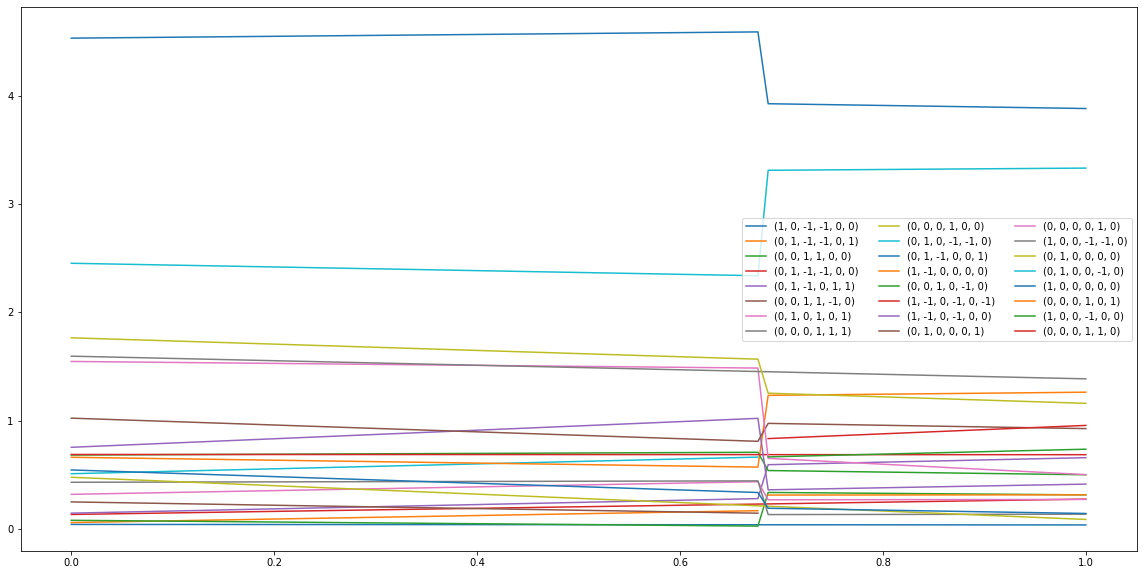

In [138]:
fig = plt.figure(figsize=(20,10))
for offset,(t,coef) in decomp.items():
    plt.plot(t,coef)
plt.legend(decomp.keys(),ncol=3)
savefig(fig,"Coefs_Vor4.pdf")

### 1.3 Case of a field of tensors

On the CPU, the decomposition time increases linearly with the number of tensors.
On the GPU, the decomposition runs on a single thread, and there e.g. $2560$ of them on a nvidia $1080$ class card. 
Therefore time is rather insensitive to the number of tensors until that number is reached.

**Note on CPU/GPU computation time**
Computation time is dominated ($90\%$) by the solution of a linear problem, with 15 variables and 36 constraints. 
Currently this is done using the following algorithm:

* Academic paper : Seidel, R. (1991), "Small-dimensional linear programming and convex hulls made easy", Discrete & Computational Geometry 6 (1): 423–434, doi:10.1007/BF02574699
* Source code : https://github.com/cgrushko/seidel-lp-solver

This algorithm appears not to be well adapted to the task at hand, since it is mostly intended for linear programs in dimension $<10$, and its complexity grows exponentially with the dimension. Also, the GPU seems not to like it (lots of branching).

<!---In the current implementation, the GPU code appears to be quite slow, in addition to being less stable due to the use of single-precision floating point variables. A multi-threaded CPU implementation--->

In [139]:
def decomp_time(n):
    np.random.seed(42)
    D = MakeRandomTensor(6,(n,))
    start = time.time()
    coefs,offsets = VoronoiDecomposition(D)
    print(f"Decomposition of {n} matrices completed in {time.time()-start} seconds")
    print("Tensor shape: ",D.shape,", max reconstruction error : ",np.max(np.abs(D-Reconstruct(coefs,offsets))))
#    assert allclose(D,Reconstruct(coefs,offsets))

In [140]:
decomp_time(10)

offset_norm2_,priority (6,21)(5,14)(4,6)(4,5)(2,2)(19,35)(14,32)(8,23)(4,8)(5,15)(5,13)(9,26)(6,20)(8,25)(4,10)(5,17)(10,28)(10,29)(16,34)(11,30)(5,16)(5,12)(3,4)(2,1)(7,22)(5,19)(3,3)(4,9)(4,7)(2,0)(5,18)(5,11)(8,24)(10,27)(14,33)(11,31)
Value of the linear program -0.995997
state.vertex2
offset_norm2_,priority (3,10)(2,5)(5,18)(7,24)(2,6)(3,11)(8,26)(12,34)(1,3)(3,12)(11,33)(2,4)(6,20)(5,19)(9,29)(4,16)(1,2)(9,28)(6,21)(4,14)(1,1)(2,8)(4,15)(11,31)(7,23)(8,25)(3,13)(15,35)(2,7)(10,30)(3,9)(4,17)(8,27)(1,0)(7,22)(11,32)
Value of the linear program -1.67158
state.vertex2
offset_norm2_,priority (2,4)(4,18)(1,1)(7,28)(2,7)(2,8)(1,2)(13,34)(2,6)(3,12)(17,35)(6,23)(8,31)(1,3)(7,27)(10,32)(3,11)(3,15)(2,5)(7,26)(11,33)(5,21)(3,14)(6,25)(4,20)(5,22)(4,17)(6,24)(1,0)(7,29)(3,13)(8,30)(2,9)(3,10)(3,16)(4,19)
Value of the linear program -2.40753
state.vertex2
offset_norm2_,priority (2,8)(4,23)(2,3)(4,24)(4,22)(4,29)(4,28)(6,34)(4,27)(2,6)(6,33)(2,7)(4,25)(2,4)(4,26)(5,30)(5,32)(7,35)(3,18)(3,13

In [141]:
decomp_time(100)

offset_norm2_,priority (6,16)(1,0)(3,3)(7,20)(3,7)(5,13)(3,5)(7,22)(11,33)(4,10)(8,28)(2,2)(8,24)(8,30)(12,34)(5,11)(5,14)(7,23)(5,12)(6,17)(4,9)(7,21)(9,31)(3,4)(8,27)(8,25)(16,35)(6,19)(8,26)(10,32)(6,15)(6,18)(8,29)(2,1)(4,8)(3,6)
Value of the linear program -5.52519e-05
state.vertex2
offset_norm2_,priority (12,28)(11,24)(7,14)(2,2)(15,32)(1,1)(3,4)(8,17)(3,7)(4,8)(7,15)(2,3)(3,5)(6,12)(11,26)(1,0)(7,13)(10,22)(3,6)(6,11)(10,21)(13,30)(8,18)(12,29)(19,34)(11,25)(4,9)(23,35)(8,19)(11,27)(5,10)(16,33)(11,23)(14,31)(7,16)(10,20)
Value of the linear program -0.382449
state.vertex2
offset_norm2_,priority (3,10)(3,14)(6,25)(4,20)(3,15)(8,29)(7,28)(9,32)(6,24)(3,12)(3,9)(2,4)(6,22)(3,7)(1,0)(11,34)(12,35)(8,30)(9,33)(6,23)(9,31)(5,21)(3,13)(2,5)(7,26)(4,18)(3,11)(1,1)(2,2)(2,3)(3,6)(4,16)(4,17)(7,27)(3,8)(4,19)
Value of the linear program -0.385658
state.vertex2
offset_norm2_,priority (5,19)(8,27)(4,12)(4,10)(6,23)(5,20)(7,26)(1,0)(5,21)(4,11)(2,4)(2,3)(4,14)(2,1)(2,5)(3,8)(11,33)(9,30)(7,

offset_norm2_,priority (10,31)(11,34)(9,30)(4,10)(4,11)(1,0)(3,7)(8,29)(2,5)(2,3)(7,25)(3,9)(5,18)(3,8)(4,12)(6,22)(4,14)(5,15)(7,24)(5,17)(13,35)(7,26)(2,4)(2,2)(8,28)(6,21)(6,20)(8,27)(6,19)(11,33)(4,13)(10,32)(2,6)(6,23)(1,1)(5,16)
Value of the linear program -33.6165
state.vertex2
offset_norm2_,priority (3,11)(4,26)(2,3)(3,10)(5,28)(3,17)(5,27)(2,2)(4,24)(4,25)(3,18)(1,0)(3,9)(3,19)(2,7)(6,29)(8,34)(7,33)(3,13)(7,31)(2,5)(4,23)(3,15)(3,12)(7,32)(4,21)(4,22)(8,35)(6,30)(3,14)(3,8)(3,16)(3,20)(1,1)(2,4)(2,6)
Value of the linear program -33.7808
state.vertex2
offset_norm2_,priority (3,13)(1,0)(4,20)(4,22)(5,25)(2,7)(1,1)(5,24)(6,27)(3,14)(3,17)(4,23)(6,26)(7,29)(1,2)(8,33)(11,34)(3,12)(2,5)(7,32)(12,35)(2,4)(4,18)(3,15)(7,30)(3,16)(2,8)(2,6)(1,3)(3,9)(4,19)(3,10)(7,31)(6,28)(4,21)(3,11)
Value of the linear program -33.7808
state.vertex2
offset_norm2_,priority (12,25)(15,32)(15,30)(2,6)(14,28)(7,16)(5,14)(12,27)(4,11)(10,20)(17,33)(3,10)(11,22)(3,9)(12,26)(5,15)(5,12)(18,34)(2,5)(2,3)(

offset_norm2_,priority (14,27)(3,3)(4,5)(6,11)(22,33)(7,15)(8,16)(12,25)(2,2)(1,0)(3,4)(11,20)(4,6)(12,24)(18,29)(6,13)(9,19)(11,22)(7,14)(20,31)(6,9)(6,12)(6,10)(9,18)(19,30)(24,34)(2,1)(27,35)(5,7)(5,8)(8,17)(12,23)(11,21)(15,28)(13,26)(20,32)
Value of the linear program -61.2093
state.vertex2
offset_norm2_,priority (3,11)(2,5)(1,0)(2,4)(4,14)(3,10)(6,21)(5,17)(7,26)(2,2)(3,8)(2,3)(6,18)(7,25)(3,6)(3,7)(4,15)(4,12)(7,24)(5,16)(6,19)(3,9)(7,23)(4,13)(6,20)(12,29)(7,22)(9,27)(2,1)(10,28)
Value of the linear program -60.938
state.vertex1
offset_norm2_,priority (7,16)(3,4)(14,32)(2,0)(3,2)(4,8)(11,28)(13,30)(8,20)(15,33)(5,11)(6,13)(22,35)(9,24)(9,23)(7,19)(8,21)(10,25)(3,5)(2,1)(11,26)(5,12)(7,17)(6,15)(3,3)(16,34)(3,6)(7,18)(8,22)(12,29)(11,27)(4,10)(6,14)(13,31)(3,7)(4,9)
Value of the linear program -60.5333
state.vertex2
offset_norm2_,priority (6,23)(11,31)(4,11)(4,14)(2,4)(3,7)(6,22)(6,25)(2,3)(5,19)(7,28)(5,20)(2,6)(2,0)(2,5)(4,15)(7,27)(7,26)(9,30)(6,24)(4,18)(4,16)(2,1)(9,29)(11,

In [143]:
decomp_time(1000)

offset_norm2_,priority (14,26)(15,28)(14,27)(15,29)(15,30)(5,13)(2,4)(7,15)(1,0)(3,9)(4,11)(2,5)(7,16)(1,2)(4,10)(14,25)(21,35)(12,23)(16,32)(16,33)(10,19)(9,17)(2,3)(3,8)(17,34)(11,21)(11,20)(12,22)(16,31)(9,18)(1,1)(7,14)(4,12)(14,24)(3,7)(3,6)
Value of the linear program 0.221272
state.vertex2
offset_norm2_,priority (3,5)(4,9)(17,21)(14,20)(11,19)(2,1)(4,11)(5,12)(6,14)(4,6)(3,2)(4,10)(10,18)(3,3)(7,15)(7,17)(4,7)(3,4)(7,16)(4,8)(1,0)(6,13)
Value of the linear program 0.239941
state.vertex5
offset_norm2_,priority (5,10)(3,5)(11,22)(5,12)(2,3)(6,14)(14,29)(12,26)(7,18)(8,19)(2,2)(3,6)(8,21)(13,27)(3,4)(16,31)(8,20)(12,23)(23,35)(4,9)(3,7)(2,1)(14,30)(6,15)(18,33)(12,24)(17,32)(6,13)(7,16)(19,34)(7,17)(14,28)(1,0)(4,8)(12,25)(5,11)
Value of the linear program 0.228339
state.vertex2
offset_norm2_,priority (10,29)(6,21)(12,33)(12,32)(15,35)(4,15)(2,4)(6,23)(1,0)(4,11)(2,2)(5,19)(4,10)(1,1)(5,18)(11,30)(7,26)(5,16)(8,28)(7,27)(3,8)(4,14)(4,13)(6,22)(5,17)(11,31)(6,20)(3,7)(4,12)(2,3)(3,6

offset_norm2_,priority (9,18)(3,7)(5,11)(17,33)(1,2)(12,25)(6,12)(28,35)(6,13)(4,10)(12,26)(2,3)(12,24)(2,5)(14,28)(16,31)(16,30)(2,4)(20,34)(10,22)(11,23)(7,17)(7,16)(3,6)(9,19)(10,20)(16,32)(4,9)(10,21)(6,14)(1,0)(13,27)(3,8)(15,29)(1,1)(7,15)
Value of the linear program -21.8657
state.vertex2
offset_norm2_,priority (7,23)(4,10)(3,6)(8,24)(3,9)(3,8)(6,19)(3,7)(4,11)(4,15)(3,5)(2,3)(5,17)(1,0)(7,22)(2,4)(2,1)(7,20)(5,18)(4,14)(14,29)(5,16)(14,28)(10,26)(4,12)(13,27)(9,25)(4,13)(2,2)(7,21)
Value of the linear program -21.6736
state.vertex1
offset_norm2_,priority (7,21)(8,26)(5,11)(8,28)(1,1)(7,23)(6,18)(7,25)(6,14)(11,34)(6,16)(7,20)(3,3)(4,9)(5,12)(6,17)(9,29)(2,2)(9,30)(6,15)(3,4)(3,5)(4,8)(9,31)(7,22)(5,10)(10,32)(10,33)(15,35)(8,27)(4,7)(3,6)(7,24)(6,13)(1,0)(6,19)
Value of the linear program -22.9174
state.vertex2
offset_norm2_,priority (4,13)(13,33)(2,4)(5,19)(3,12)(17,35)(8,24)(11,30)(3,10)(13,32)(4,15)(10,28)(3,8)(3,6)(4,14)(3,9)(10,29)(3,11)(9,26)(5,18)(1,0)(4,17)(11,31)(6,21)

offset_norm2_,priority (5,19)(3,6)(11,33)(6,23)(2,4)(2,5)(4,10)(5,18)(3,9)(6,25)(5,17)(1,0)(5,20)(5,21)(4,12)(1,2)(5,22)(4,13)(2,3)(3,8)(8,28)(7,26)(4,15)(14,34)(11,32)(4,14)(4,16)(10,30)(6,24)(7,27)(3,7)(1,1)(15,35)(9,29)(4,11)(11,31)
Value of the linear program -52.1806
state.vertex2
offset_norm2_,priority (8,25)(6,15)(2,1)(1,0)(3,6)(2,3)(8,24)(11,30)(15,35)(8,22)(7,20)(13,33)(3,9)(7,17)(6,16)(10,26)(6,14)(3,8)(3,7)(4,10)(14,34)(3,4)(4,11)(12,31)(8,23)(5,13)(3,5)(11,29)(11,27)(12,32)(11,28)(7,19)(7,18)(5,12)(2,2)(7,21)
Value of the linear program -51.5627
state.vertex2
offset_norm2_,priority (2,6)(2,5)(4,16)(3,9)(3,8)(6,23)(2,2)(3,7)(5,18)(6,22)(7,28)(7,27)(5,17)(7,24)(6,19)(3,10)(3,11)(8,31)(8,30)(1,1)(1,0)(2,4)(7,25)(7,26)(8,29)(6,20)(8,32)(4,15)(4,14)(11,34)(4,12)(4,13)(8,33)(6,21)(11,35)(2,3)
Value of the linear program -51.2438
state.vertex2
offset_norm2_,priority (1,1)(4,10)(1,0)(5,14)(1,2)(5,13)(2,3)(4,11)(2,4)(3,8)(7,24)(3,6)(8,26)(2,5)(4,12)(3,7)(6,16)(8,27)(8,25)(7,22)(4,9)

offset_norm2_,priority (1,0)(1,1)(3,9)(14,34)(6,22)(2,3)(2,6)(13,32)(5,18)(4,13)(11,29)(5,19)(19,35)(7,24)(4,15)(12,30)(14,33)(5,16)(3,10)(12,31)(11,28)(2,8)(11,27)(5,20)(5,17)(7,23)(3,11)(1,2)(3,12)(8,25)(6,21)(2,7)(2,5)(4,14)(9,26)(2,4)
Value of the linear program -69.0327
state.vertex2
offset_norm2_,priority (4,25)(4,26)(1,0)(3,17)(2,4)(4,29)(3,18)(3,12)(2,8)(3,20)(7,35)(4,27)(4,24)(1,1)(5,31)(2,7)(1,3)(5,33)(2,10)(3,14)(3,16)(3,13)(1,2)(2,9)(2,11)(3,15)(2,5)(4,28)(3,19)(3,21)(5,32)(4,23)(4,30)(3,22)(5,34)(2,6)
Value of the linear program -69.4963
state.vertex2
offset_norm2_,priority (2,1)(8,22)(4,11)(4,9)(6,15)(12,30)(6,17)(6,16)(6,14)(18,34)(8,21)(14,31)(6,18)(4,10)(2,2)(21,35)(11,28)(7,19)(5,12)(11,27)(9,23)(3,5)(11,29)(3,6)(10,26)(17,33)(9,25)(3,4)(3,8)(1,0)(15,32)(9,24)(3,3)(5,13)(3,7)(7,20)
Value of the linear program -69.768
state.vertex2
offset_norm2_,priority (3,13)(4,20)(5,26)(9,33)(5,25)(3,16)(2,9)(10,34)(4,23)(1,2)(3,18)(1,1)(6,28)(2,6)(2,10)(8,32)(11,35)(3,14)(7,31)(4,2

offset_norm2_,priority (3,10)(1,1)(6,32)(3,17)(3,16)(4,20)(5,28)(6,33)(4,21)(5,27)(4,25)(4,23)(5,31)(3,18)(2,7)(5,29)(4,22)(3,15)(3,13)(2,9)(5,30)(3,14)(2,8)(7,35)(2,2)(3,11)(1,0)(2,4)(2,5)(3,19)(2,6)(2,3)(5,26)(7,34)(4,24)(3,12)
Value of the linear program -95.7842
state.vertex2
offset_norm2_,priority (1,0)(2,7)(12,31)(6,19)(2,5)(3,11)(13,33)(7,22)(1,1)(6,21)(2,6)(2,2)(4,17)(8,27)(4,14)(17,34)(5,18)(11,29)(19,35)(4,13)(3,9)(2,3)(4,16)(4,15)(13,32)(8,26)(10,28)(4,12)(2,4)(6,20)(7,23)(11,30)(3,8)(3,10)(7,24)(8,25)
Value of the linear program -95.7842
state.vertex2
offset_norm2_,priority (5,16)(2,2)(3,4)(7,21)(2,1)(7,23)(6,19)(16,35)(7,22)(3,5)(5,14)(2,0)(8,26)(5,11)(11,31)(5,15)(6,18)(8,24)(9,28)(3,6)(2,3)(3,7)(11,33)(6,20)(9,27)(13,34)(8,25)(10,29)(5,12)(11,32)(6,17)(5,13)(5,10)(4,9)(4,8)(10,30)
Value of the linear program -96.188
state.vertex2
offset_norm2_,priority (3,16)(3,17)(5,28)(11,34)(4,23)(2,4)(4,21)(12,35)(3,14)(2,7)(6,30)(1,1)(4,22)(1,2)(5,27)(11,33)(7,31)(3,13)(8,32)(3,19)(

offset_norm2_,priority (2,9)(7,26)(6,23)(11,34)(5,18)(5,20)(4,15)(11,35)(3,14)(1,1)(4,17)(2,7)(7,29)(1,2)(6,24)(6,25)(7,28)(8,30)(8,31)(2,6)(2,10)(3,13)(8,32)(5,21)(3,11)(7,27)(1,0)(4,16)(2,4)(5,22)(5,19)(1,3)(2,5)(2,8)(3,12)(9,33)
Value of the linear program -117.972
state.vertex2
offset_norm2_,priority (11,24)(15,32)(13,29)(4,8)(6,14)(4,11)(4,7)(11,26)(7,15)(8,21)(17,34)(7,18)(17,33)(5,12)(12,27)(3,5)(5,13)(12,28)(2,2)(3,6)(18,35)(13,30)(2,1)(4,9)(1,0)(8,19)(4,10)(10,23)(8,20)(15,31)(7,16)(9,22)(7,17)(11,25)(2,3)(3,4)
Value of the linear program -120.067
state.vertex2
offset_norm2_,priority (16,33)(2,2)(11,25)(9,19)(4,6)(14,30)(13,28)(25,35)(8,16)(5,8)(5,9)(2,0)(14,31)(3,5)(11,26)(10,23)(9,20)(7,12)(14,29)(9,21)(7,13)(7,14)(7,11)(4,7)(6,10)(19,34)(12,27)(8,18)(9,22)(11,24)(3,4)(8,15)(2,1)(15,32)(3,3)(8,17)
Value of the linear program -120.396
state.vertex2
offset_norm2_,priority (1,0)(3,14)(1,1)(3,18)(2,9)(6,32)(2,5)(4,27)(3,16)(4,23)(4,28)(7,34)(4,25)(3,17)(7,35)(2,8)(2,3)(4,26)(5,3

offset_norm2_,priority (8,35)(4,19)(3,10)(4,18)(5,24)(4,13)(5,23)(6,28)(3,8)(1,3)(2,5)(1,1)(3,11)(2,7)(1,0)(5,21)(6,29)(7,32)(6,27)(4,16)(4,15)(1,2)(4,17)(3,9)(8,33)(5,20)(2,4)(6,30)(3,12)(6,26)(5,25)(6,31)(4,14)(5,22)(8,34)(2,6)
Value of the linear program -131.465
state.vertex2
offset_norm2_,priority (10,20)(1,0)(23,33)(2,2)(4,8)(5,12)(7,14)(14,27)(6,13)(16,30)(3,5)(3,4)(25,35)(15,28)(8,17)(8,15)(12,25)(11,24)(3,3)(5,11)(19,32)(5,10)(10,23)(4,9)(10,22)(24,34)(8,16)(8,18)(2,1)(15,29)(10,21)(4,7)(14,26)(18,31)(3,6)(9,19)
Value of the linear program -131.768
state.vertex2
offset_norm2_,priority (9,8)(10,11)(6,7)(29,31)(2,0)(23,25)(13,16)(26,29)(15,21)(24,27)(65,35)(14,20)(13,17)(12,14)(37,33)(21,23)(3,2)(22,24)(11,12)(12,15)(9,9)(14,19)(3,4)(25,28)(2,1)(3,5)(32,32)(27,30)(6,6)(13,18)(10,10)(23,26)(40,34)(3,3)(20,22)(11,13)
Value of the linear program -131.591
state.vertex2
offset_norm2_,priority (10,27)(19,34)(10,26)(3,4)(10,25)(7,18)(4,8)(11,29)(8,21)(3,5)(14,31)(5,12)(9,23)(2,1)(7,16)

Value of the linear program -150.4
state.vertex2
offset_norm2_,priority (4,21)(3,15)(5,24)(6,27)(4,20)(2,9)(7,28)(2,5)(2,7)(2,4)(2,8)(3,13)(3,11)(3,14)(5,22)(7,29)(3,12)(2,6)(4,17)(4,19)(6,26)(1,2)(3,16)(5,23)(4,18)(2,3)(6,25)(3,10)(1,1)(1,0)
Value of the linear program -157.09
state.vertex1
offset_norm2_,priority (11,34)(7,30)(13,35)(4,14)(4,13)(6,21)(8,31)(5,15)(7,23)(4,8)(1,1)(5,16)(5,18)(7,25)(4,6)(4,11)(4,10)(7,29)(9,32)(4,7)(7,28)(4,12)(1,0)(3,3)(3,5)(7,26)(7,27)(5,17)(7,24)(10,33)(4,9)(2,2)(6,20)(6,19)(3,4)(6,22)
Value of the linear program -158.164
state.vertex2
offset_norm2_,priority (4,12)(6,18)(5,16)(6,20)(1,1)(12,29)(3,7)(16,33)(3,8)(13,30)(6,17)(7,22)(21,35)(2,5)(11,27)(3,6)(10,26)(5,15)(4,13)(4,9)(8,24)(7,21)(14,31)(1,0)(4,11)(19,34)(4,14)(2,2)(7,23)(6,19)(11,28)(4,10)(2,4)(15,32)(2,3)(8,25)
Value of the linear program -159.647
state.vertex2
offset_norm2_,priority (15,27)(7,15)(35,35)(17,29)(23,32)(4,9)(8,17)(2,4)(2,5)(14,26)(4,6)(6,12)(10,20)(6,13)(2,0)(29,34)(11,23)(19,

offset_norm2_,priority (4,17)(15,35)(8,31)(5,19)(7,30)(7,27)(4,12)(3,11)(3,7)(7,28)(6,23)(4,14)(5,21)(1,1)(4,16)(2,4)(3,8)(6,24)(2,2)(2,3)(6,25)(13,34)(10,33)(5,20)(3,6)(5,22)(3,9)(4,15)(4,13)(3,10)(7,26)(7,29)(2,5)(4,18)(1,0)(9,32)
Value of the linear program -180.44
state.vertex2
offset_norm2_,priority (6,13)(7,18)(5,10)(6,14)(11,22)(3,7)(1,1)(14,24)(3,8)(6,16)(15,28)(2,3)(13,23)(6,17)(15,29)(2,2)(6,15)(23,32)(2,4)(3,5)(1,0)(4,9)(17,30)(15,27)(21,31)(24,33)(5,12)(28,35)(3,6)(24,34)(10,20)(7,19)(14,26)(5,11)(14,25)(11,21)
Value of the linear program -180.383
state.vertex2
offset_norm2_,priority (5,14)(6,15)(9,19)(4,10)(3,9)(3,8)(14,27)(1,0)(2,4)(11,22)(2,5)(7,18)(11,21)(14,26)(3,6)(12,24)(5,12)(16,29)(23,34)(4,11)(1,1)(1,2)(14,25)(5,13)(23,33)(11,23)(14,28)(6,16)(11,20)(20,32)(16,30)(17,31)(3,7)(6,17)(23,35)(2,3)
Value of the linear program -180.131
state.vertex2
offset_norm2_,priority (8,18)(3,3)(6,12)(10,21)(1,0)(13,27)(8,19)(12,26)(5,8)(5,9)(7,16)(4,5)(4,6)(7,14)(9,20)(15,31)(6,13)

offset_norm2_,priority (9,27)(5,17)(7,25)(3,9)(6,20)(6,19)(2,4)(4,14)(3,8)(4,12)(2,1)(7,22)(4,11)(3,6)(3,10)(7,24)(7,21)(9,26)(10,28)(11,30)(2,2)(3,7)(5,18)(5,16)(16,33)(17,35)(12,32)(11,29)(12,31)(16,34)(2,5)(1,0)(2,3)(7,23)(5,15)(4,13)
Value of the linear program -203.329
state.vertex2
offset_norm2_,priority (6,20)(3,9)(5,14)(8,28)(7,25)(3,6)(1,0)(10,30)(7,24)(2,3)(3,5)(4,10)(7,26)(4,11)(5,18)(12,33)(16,35)(5,16)(6,23)(9,29)(15,34)(4,13)(3,8)(3,4)(11,31)(6,21)(3,7)(4,12)(5,19)(2,1)(6,22)(5,17)(8,27)(11,32)(2,2)(5,15)
Value of the linear program -203.641
state.vertex2
offset_norm2_,priority (5,13)(7,14)(11,28)(8,20)(13,31)(2,2)(4,9)(5,12)(4,10)(4,11)(7,16)(8,23)(11,26)(8,19)(3,7)(17,35)(11,27)(16,33)(9,24)(13,30)(8,21)(2,1)(7,15)(3,5)(12,29)(16,34)(7,17)(8,22)(3,4)(14,32)(7,18)(4,8)(1,0)(2,3)(9,25)(3,6)
Value of the linear program -203.825
state.vertex2
offset_norm2_,priority (1,0)(7,26)(3,11)(8,31)(2,5)(10,34)(4,17)(9,32)(3,8)(8,29)(3,13)(3,9)(9,33)(5,22)(4,20)(3,10)(15,35)(4,16)(8,2

offset_norm2_,priority (1,0)(13,31)(4,12)(2,6)(2,7)(18,33)(5,16)(1,2)(1,3)(11,29)(19,34)(23,35)(8,21)(6,17)(2,8)(9,25)(2,5)(8,20)(8,23)(16,32)(11,28)(8,22)(4,15)(3,9)(4,13)(10,27)(6,18)(1,1)(3,11)(9,24)(7,19)(3,10)(2,4)(4,14)(12,30)(10,26)
Value of the linear program -220.757
state.vertex2
offset_norm2_,priority (2,3)(2,5)(3,8)(9,25)(10,27)(2,4)(1,0)(5,17)(6,18)(3,10)(7,21)(8,22)(4,15)(3,6)(9,24)(16,35)(11,30)(13,32)(4,14)(11,29)(7,20)(1,1)(3,12)(6,19)(14,34)(13,33)(4,13)(10,26)(3,11)(3,7)(11,31)(2,2)(10,28)(3,9)(5,16)(8,23)
Value of the linear program -220.968
state.vertex2
offset_norm2_,priority (4,5)(4,7)(8,20)(15,28)(10,22)(6,14)(10,25)(15,29)(4,6)(2,1)(7,15)(8,18)(5,8)(8,19)(7,17)(26,35)(18,32)(7,16)(18,33)(22,34)(14,27)(6,13)(3,4)(5,10)(17,31)(11,26)(10,23)(9,21)(6,11)(1,0)(5,9)(10,24)(3,3)(6,12)(3,2)(15,30)
Value of the linear program -221.451
state.vertex2
offset_norm2_,priority (2,1)(9,34)(6,26)(3,10)(5,23)(9,33)(6,27)(3,9)(3,7)(9,35)(4,20)(4,22)(3,13)(3,11)(2,4)(7,30)(8,31)(9

offset_norm2_,priority (7,17)(3,5)(6,12)(6,13)(10,19)(3,7)(2,2)(2,4)(5,11)(7,16)(7,14)(2,1)(2,3)(11,20)(3,6)(5,10)(3,8)(4,9)(12,21)(1,0)(8,18)(7,15)
Value of the linear program -236.751
state.vertex5
offset_norm2_,priority (10,23)(7,14)(2,3)(2,1)(6,11)(3,5)(8,16)(10,22)(2,4)(7,12)(9,18)(1,0)(2,2)(4,7)(6,10)(8,15)(11,25)(19,31)(7,13)(12,26)(4,6)(4,8)(10,21)(17,30)(35,34)(20,32)(8,17)(35,35)(13,27)(21,33)(10,20)(10,19)(15,29)(5,9)(11,24)(14,28)
Value of the linear program -236.751
state.vertex2
offset_norm2_,priority (7,15)(6,14)(1,0)(9,23)(5,11)(17,31)(8,17)(22,34)(4,8)(3,5)(7,16)(17,32)(6,12)(6,13)(14,29)(3,4)(8,21)(4,9)(24,35)(5,10)(2,2)(2,3)(8,18)(11,26)(8,22)(11,25)(3,7)(8,19)(10,24)(12,27)(2,1)(8,20)(3,6)(19,33)(15,30)(14,28)
Value of the linear program -236.914
state.vertex2
offset_norm2_,priority (2,10)(2,8)(2,6)(1,1)(4,17)(3,15)(2,9)(3,16)(6,27)(1,0)(4,21)(1,4)(4,20)(7,29)(3,12)(4,18)(3,14)(3,11)(4,22)(5,25)(2,5)(1,3)(4,19)(3,13)(1,2)(6,26)(5,24)(5,23)(2,7)(7,28)
Value of the li

offset_norm2_,priority (4,12)(6,20)(1,0)(12,30)(4,10)(2,2)(5,15)(10,29)(2,3)(7,25)(18,35)(4,11)(17,34)(3,6)(16,33)(3,4)(6,19)(9,28)(3,7)(8,27)(4,9)(8,26)(3,5)(6,18)(3,8)(5,13)(5,14)(12,31)(12,32)(7,23)(7,24)(7,22)(6,16)(6,17)(7,21)(2,1)
Value of the linear program -248.863
state.vertex2
offset_norm2_,priority (6,16)(6,18)(9,28)(4,14)(12,34)(2,4)(1,1)(8,27)(6,17)(1,0)(6,20)(2,3)(9,30)(3,8)(8,26)(9,29)(10,32)(13,35)(3,10)(6,19)(10,31)(8,23)(3,12)(2,7)(7,21)(11,33)(3,9)(8,25)(2,5)(7,22)(3,11)(5,15)(4,13)(8,24)(1,2)(2,6)
Value of the linear program -248.27
state.vertex2
offset_norm2_,priority (7,13)(6,9)(10,17)(3,3)(17,28)(5,8)(1,1)(6,10)(4,6)(10,18)(1,0)(15,26)(11,19)(3,2)(16,27)(6,12)(20,32)(9,16)(19,30)(9,15)(12,22)(20,31)(3,4)(19,29)(31,34)(12,24)(6,11)(12,23)(28,33)(9,14)(3,5)(13,25)(11,20)(43,35)(12,21)(4,7)
Value of the linear program -248.296
state.vertex2
offset_norm2_,priority (1,1)(3,12)(5,25)(4,22)(3,20)(2,5)(4,21)(3,17)(2,11)(1,0)(2,7)(1,4)(4,23)(1,2)(3,16)(4,24)(3,13)(7,29)(2

offset_norm2_,priority (2,5)(2,1)(15,35)(4,11)(5,19)(4,13)(11,30)(6,21)(5,17)(11,31)(2,2)(3,10)(7,26)(4,14)(1,0)(13,34)(8,29)(7,25)(8,28)(2,7)(6,22)(7,27)(2,3)(11,32)(6,24)(5,18)(4,12)(2,8)(5,20)(2,4)(3,9)(4,15)(6,23)(11,33)(2,6)(4,16)
Value of the linear program -256.373
state.vertex2
offset_norm2_,priority (3,10)(5,19)(1,3)(8,25)(1,2)(12,35)(4,17)(11,32)(2,4)(8,26)(3,11)(8,21)(11,34)(2,8)(9,28)(2,6)(10,30)(3,9)(8,24)(6,20)(3,14)(3,13)(8,23)(2,7)(4,18)(11,31)(2,5)(3,12)(8,27)(1,0)(8,22)(1,1)(4,16)(11,33)(4,15)(10,29)
Value of the linear program -257.01
state.vertex2
offset_norm2_,priority (5,16)(4,13)(5,18)(3,10)(8,32)(5,20)(2,2)(6,25)(5,22)(5,21)(3,7)(2,4)(8,34)(7,30)(5,14)(3,9)(10,35)(8,31)(3,8)(3,11)(6,26)(3,6)(7,29)(2,3)(5,17)(7,27)(2,5)(6,24)(1,0)(5,19)(4,12)(5,15)(7,28)(8,33)(6,23)(2,1)
Value of the linear program -258.596
state.vertex2
offset_norm2_,priority (3,7)(18,29)(11,27)(7,19)(9,23)(7,20)(8,22)(2,2)(4,11)(4,14)(3,5)(5,16)(5,17)(5,15)(4,13)(2,3)(4,12)(2,1)(4,9)(4,10)(10,2

offset_norm2_,priority (3,8)(5,20)(4,13)(8,32)(4,14)(4,11)(7,26)(9,33)(5,18)(3,6)(5,21)(3,7)(2,5)(2,0)(4,16)(7,28)(4,15)(2,1)(6,24)(6,23)(3,9)(8,29)(8,31)(11,35)(8,30)(4,12)(6,22)(7,27)(7,25)(5,19)(3,10)(5,17)(2,3)(2,2)(2,4)(10,34)
Value of the linear program -286.437
state.vertex2
offset_norm2_,priority (14,19)(3,3)(7,9)(12,14)(23,28)(11,12)(31,31)(22,25)(5,6)(14,20)(15,21)(22,27)(7,10)(32,32)(19,22)(33,33)(13,16)(6,8)(25,29)(36,35)(14,18)(3,1)(4,5)(6,7)(13,15)(19,23)(14,17)(27,30)(4,4)(1,0)(11,13)(34,34)(3,2)(8,11)(19,24)(22,26)
Value of the linear program -286.856
state.vertex2
offset_norm2_,priority (5,10)(7,15)(14,34)(13,32)(11,29)(2,0)(7,17)(8,19)(4,5)(11,28)(6,12)(4,7)(11,26)(3,2)(4,3)(14,33)(11,27)(12,30)(6,11)(5,9)(4,4)(4,8)(9,24)(14,35)(10,25)(12,31)(4,6)(9,23)(7,14)(8,18)(9,22)(3,1)(8,20)(8,21)(7,16)(6,13)
Value of the linear program -286.868
state.vertex2
offset_norm2_,priority (3,8)(6,28)(3,9)(8,35)(6,26)(3,13)(4,19)(3,14)(1,1)(7,32)(4,18)(4,20)(5,24)(5,23)(2,6)(7,30)(6,27

offset_norm2_,priority (12,29)(8,19)(17,34)(11,24)(13,31)(2,1)(1,0)(5,12)(3,5)(3,4)(3,7)(3,6)(4,9)(2,2)(2,3)(14,33)(11,25)(11,26)(7,16)(9,23)(13,30)(6,13)(4,8)(9,22)(17,35)(13,32)(7,17)(8,21)(4,10)(8,20)(7,15)(5,11)(12,28)(12,27)(6,14)(8,18)
Value of the linear program -304.577
state.vertex2
offset_norm2_,priority (3,8)(6,17)(2,4)(10,27)(13,31)(11,29)(5,13)(13,32)(16,33)(2,3)(4,9)(7,18)(4,11)(7,20)(1,0)(13,30)(17,34)(7,22)(6,16)(10,26)(7,19)(7,23)(17,35)(11,28)(8,24)(6,15)(5,12)(4,10)(3,6)(7,21)(3,5)(2,1)(3,7)(2,2)(6,14)(8,25)
Value of the linear program -304.612
state.vertex2
offset_norm2_,priority (1,0)(3,2)(2,1)(20,31)(8,12)(4,6)(3,3)(23,32)(9,13)(5,9)(25,33)(13,19)(28,34)(10,14)(44,35)(4,8)(3,4)(17,30)(15,27)(3,5)(4,7)(13,21)(11,15)(8,11)(6,10)(17,29)(13,22)(12,18)(14,25)(14,23)(16,28)(14,24)(11,17)(15,26)(13,20)(11,16)
Value of the linear program -304.65
state.vertex2
offset_norm2_,priority (4,19)(4,17)(2,3)(4,16)(4,14)(8,33)(4,20)(8,34)(2,4)(4,18)(6,27)(4,13)(10,35)(4,15)(6,26)(1

offset_norm2_,priority (3,1)(11,28)(6,15)(7,19)(6,16)(16,31)(11,27)(12,29)(7,22)(3,2)(22,35)(5,10)(19,33)(4,5)(13,30)(3,3)(6,14)(21,34)(6,13)(10,25)(7,20)(18,32)(7,18)(4,6)(1,0)(7,21)(4,9)(8,23)(3,4)(10,24)(4,8)(5,11)(5,12)(4,7)(11,26)(7,17)
Value of the linear program -321.291
state.vertex2
offset_norm2_,priority (5,20)(1,1)(8,31)(1,2)(4,16)(4,15)(3,13)(4,17)(1,0)(7,29)(2,4)(3,8)(5,22)(4,19)(3,10)(9,32)(2,6)(7,27)(4,18)(6,24)(3,9)(2,5)(7,28)(2,7)(11,34)(17,35)(10,33)(6,25)(1,3)(8,30)(6,26)(5,23)(3,11)(4,14)(3,12)(5,21)
Value of the linear program -321.108
state.vertex2
offset_norm2_,priority (3,13)(1,1)(24,22)(1,0)(2,10)(1,2)(31,25)(2,9)(3,12)(4,17)(31,24)(2,5)(1,4)(2,7)(25,23)(38,28)(21,20)(3,15)(2,6)(3,16)(38,27)(3,14)(2,8)(5,19)(37,26)(24,21)(43,29)(1,3)(4,18)(3,11)
Value of the linear program -321.709
state.vertex1
offset_norm2_,priority (2,6)(4,19)(1,1)(4,18)(4,17)(4,14)(1,0)(6,22)(4,13)(3,9)(8,31)(6,23)(3,8)(3,7)(2,2)(4,15)(7,28)(6,24)(6,25)(3,10)(5,21)(3,11)(6,26)(11,35)(11,34)

offset_norm2_,priority (4,26)(1,2)(2,6)(2,3)(3,13)(5,33)(4,24)(2,7)(3,17)(3,18)(3,19)(4,31)(4,25)(3,16)(1,1)(3,12)(4,27)(4,29)(3,20)(5,32)(3,15)(2,5)(2,9)(3,22)(4,30)(3,14)(2,8)(2,10)(3,21)(3,23)(3,11)(2,4)(4,28)(5,34)(7,35)(1,0)
Value of the linear program -346.033
state.vertex2
offset_norm2_,priority (8,22)(20,26)(10,24)(7,18)(6,14)(9,23)(2,3)(1,2)(2,5)(1,0)(4,11)(5,12)(6,17)(7,21)(3,9)(2,4)(3,8)(1,1)(2,6)(3,10)(18,25)(21,28)(24,29)(21,27)(3,7)(6,15)(5,13)(7,20)(6,16)(7,19)
Value of the linear program -345.985
state.vertex1
offset_norm2_,priority (2,5)(6,21)(9,31)(5,20)(4,11)(8,29)(11,33)(3,10)(8,28)(1,1)(7,27)(4,13)(10,32)(5,17)(7,26)(5,18)(4,15)(12,34)(7,25)(8,30)(6,22)(14,35)(2,4)(3,8)(2,7)(2,3)(5,19)(1,0)(6,23)(4,12)(4,14)(1,2)(3,9)(2,6)(4,16)(7,24)
Value of the linear program -345.977
state.vertex2
offset_norm2_,priority (4,9)(4,10)(15,27)(10,19)(5,11)(6,12)(13,24)(2,4)(1,0)(8,17)(7,15)(4,8)(1,1)(6,13)(13,23)(8,18)(17,29)(3,6)(16,28)(7,14)(11,20)(2,2)(3,7)(14,25)(11,21)(12,22)(1

offset_norm2_,priority (8,20)(3,6)(3,5)(12,28)(11,24)(5,13)(7,18)(16,33)(7,17)(2,3)(5,11)(4,8)(9,22)(4,9)(7,15)(22,35)(22,34)(11,25)(14,30)(15,31)(13,29)(2,2)(3,7)(1,0)(15,32)(10,23)(5,12)(8,19)(7,16)(2,1)(8,21)(11,27)(4,10)(11,26)(6,14)(3,4)
Value of the linear program -362.165
state.vertex2
offset_norm2_,priority (14,26)(11,17)(13,23)(6,11)(2,2)(27,35)(5,6)(12,21)(8,14)(12,22)(23,34)(17,31)(15,27)(11,18)(6,10)(3,5)(5,9)(12,20)(8,12)(14,24)(14,25)(8,13)(9,15)(5,8)(2,3)(17,32)(15,28)(5,7)(1,0)(20,33)(3,4)(1,1)(15,29)(11,19)(16,30)(10,16)
Value of the linear program -362.283
state.vertex2
offset_norm2_,priority (8,30)(2,4)(14,34)(3,8)(9,31)(4,17)(4,16)(7,28)(3,11)(8,29)(3,13)(7,25)(7,27)(5,19)(6,22)(4,15)(2,3)(3,10)(3,6)(2,1)(6,23)(5,20)(2,5)(10,32)(2,2)(11,33)(3,9)(5,21)(3,7)(6,24)(1,0)(3,12)(7,26)(15,35)(4,14)(5,18)
Value of the linear program -364.001
state.vertex2
offset_norm2_,priority (3,9)(3,8)(4,18)(1,1)(3,10)(3,12)(3,11)(4,15)(2,3)(2,6)(5,23)(2,2)(2,5)(6,26)(5,22)(5,20)(1,0)(2,

offset_norm2_,priority (1,0)(11,33)(6,22)(2,4)(1,2)(14,34)(7,24)(5,16)(2,5)(5,20)(11,32)(8,27)(10,28)(3,8)(3,7)(3,10)(6,21)(8,26)(7,25)(10,29)(11,31)(15,35)(5,19)(2,6)(5,18)(4,15)(3,9)(1,1)(4,12)(4,13)(3,11)(4,14)(2,3)(7,23)(5,17)(10,30)
Value of the linear program -387.094
state.vertex2
offset_norm2_,priority (6,25)(3,16)(2,5)(3,13)(3,17)(9,34)(6,26)(3,14)(13,35)(3,15)(4,18)(2,6)(5,23)(5,24)(6,27)(2,9)(7,31)(8,33)(2,8)(4,19)(4,20)(7,30)(4,21)(1,2)(1,4)(1,1)(7,29)(2,10)(6,28)(3,11)(5,22)(1,3)(8,32)(2,7)(3,12)(1,0)
Value of the linear program -387.406
state.vertex2
offset_norm2_,priority (8,18)(9,21)(6,9)(7,16)(7,15)(11,25)(6,11)(15,30)(11,26)(3,4)(6,12)(10,24)(3,6)(3,5)(2,0)(25,35)(22,34)(15,29)(19,32)(13,28)(17,31)(2,2)(3,3)(2,1)(19,33)(12,27)(8,17)(7,13)(7,14)(10,23)(8,19)(8,20)(5,8)(9,22)(4,7)(6,10)
Value of the linear program -388.601
state.vertex2
offset_norm2_,priority (5,10)(8,16)(17,29)(11,22)(5,12)(13,24)(22,32)(16,28)(4,9)(5,11)(1,0)(7,13)(2,3)(10,20)(8,15)(30,34)(15,25)(23,3

offset_norm2_,priority (5,13)(3,7)(5,14)(3,6)(6,18)(8,23)(2,2)(2,1)(5,15)(10,28)(6,17)(7,19)(2,3)(9,26)(3,8)(3,4)(15,31)(9,25)(10,27)(3,9)(8,24)(3,5)(5,16)(15,30)(20,34)(1,0)(4,12)(11,29)(8,22)(8,21)(4,10)(7,20)(22,35)(19,33)(17,32)(4,11)
Value of the linear program -400.303
state.vertex2
offset_norm2_,priority (1,0)(7,31)(2,6)(3,10)(1,1)(8,34)(3,12)(6,25)(2,4)(3,13)(6,26)(6,27)(3,11)(1,2)(2,5)(5,23)(4,21)(3,18)(5,24)(6,28)(7,33)(7,32)(6,29)(3,15)(6,30)(5,22)(3,14)(2,7)(2,8)(3,17)(4,19)(4,20)(1,3)(3,16)(2,9)(9,35)
Value of the linear program -400.304
state.vertex2
offset_norm2_,priority (2,3)(1,1)(7,28)(2,5)(4,21)(3,9)(9,34)(4,17)(2,6)(4,16)(3,10)(5,22)(7,29)(11,35)(4,19)(5,23)(3,15)(6,27)(6,24)(8,33)(4,20)(2,4)(3,11)(3,12)(4,18)(7,31)(3,7)(7,30)(1,2)(6,26)(3,14)(3,8)(3,13)(1,0)(6,25)(8,32)
Value of the linear program -404.409
state.vertex2
offset_norm2_,priority (7,19)(6,16)(10,28)(8,23)(2,1)(3,6)(9,24)(9,25)(7,18)(8,21)(8,22)(6,15)(4,11)(16,35)(12,32)(6,17)(4,8)(4,9)(14,34)(3,7)(6,14

offset_norm2_,priority (10,29)(6,17)(7,20)(5,15)(5,12)(6,19)(3,4)(11,34)(3,3)(5,13)(3,6)(5,14)(8,25)(2,2)(10,30)(4,7)(7,22)(7,21)(7,23)(1,0)(11,31)(4,8)(4,11)(3,5)(9,26)(11,33)(1,1)(6,18)(4,10)(4,9)(11,32)(9,27)(10,28)(16,35)(6,16)(8,24)
Value of the linear program -423.842
state.vertex2
offset_norm2_,priority (7,23)(5,18)(4,12)(9,27)(7,24)(8,26)(11,34)(10,28)(2,4)(5,17)(4,11)(4,13)(3,10)(11,35)(8,25)(3,8)(6,19)(3,6)(11,33)(6,21)(1,0)(1,2)(6,20)(5,15)(2,3)(3,9)(3,7)(10,29)(2,5)(1,1)(4,14)(10,30)(7,22)(5,16)(10,31)(11,32)
Value of the linear program -423.723
state.vertex2
offset_norm2_,priority (5,17)(4,13)(7,26)(5,16)(7,24)(7,22)(8,28)(6,18)(8,27)(3,8)(1,1)(1,0)(6,20)(4,14)(2,3)(11,33)(16,35)(12,34)(10,32)(7,23)(8,29)(6,21)(2,2)(3,9)(10,31)(3,7)(3,6)(4,12)(6,19)(2,4)(4,10)(4,11)(7,25)(9,30)(5,15)(2,5)
Value of the linear program -424.67
state.vertex2
offset_norm2_,priority (4,6)(10,25)(11,26)(6,11)(7,13)(14,31)(19,34)(8,21)(7,12)(7,16)(2,2)(15,33)(7,17)(8,20)(9,22)(10,23)(3,5)(10,24)(1

In [18]:
decomp_time(1000)

Decomposition of 1000 matrices completed in 34.66093301773071 seconds
Tensor shape:  (6, 6, 1000) , max reconstruction error :  3.2862601528904634e-13


On the GPU, decomposition time should be mostly insensitive to $n\leq 2500$, and scale linearly with $n$ beyond that limit. 

<!---
TODO : investigate this GPU failure, which is probably due to roundoff errors.
Decomposition of 10000 matrices completed in 73.4375216960907 seconds
Tensor shape:  (6, 6, 10000) , max reconstruction error :  7.562082901426454

CPU does not fail here.
Decomposition of 10000 matrices completed in 340.8524580001831 seconds
Tensor shape:  (6, 6, 10000) , max reconstruction error :  5.329070518200751e-13
--->

In [65]:
if large_instances: decomp_time(10000)

Decomposition of 10000 matrices completed in 73.4375216960907 seconds
Tensor shape:  (6, 6, 10000) , max reconstruction error :  7.562082901426454


In [19]:
decomp_time(10000)

Decomposition of 10000 matrices completed in 340.8524580001831 seconds
Tensor shape:  (6, 6, 10000) , max reconstruction error :  5.329070518200751e-13


### 2. Case of a Hooke tensor

The hooke tensor is a $(3,3,3,3)$ shaped tensor characterizing the elastic properties of a physical medium.
It has various symmetries, and can be regarded as a quadratic form on the space of $6 \times 6$ symmetric matrices.

In [144]:
hooke,ρ = Seismic.Hooke.mica # Hooke tensor of the mica medium, vertically aligned
hooke = hooke.rotate_by(0.5, (1,2,3)) # Rotate around some arbitrary axis

In [145]:
coefs,moffsets = hooke.Selling()

offset_norm2_,priority (1,2)(3,20)(2,6)(5,26)(4,22)(2,9)(1,0)(6,30)(3,16)(3,18)(8,35)(7,34)(5,27)(2,8)(3,12)(7,33)(4,21)(3,19)(4,25)(4,24)(5,28)(2,7)(3,14)(6,31)(3,15)(3,11)(2,4)(2,10)(3,17)(6,32)(2,5)(3,13)(1,3)(4,23)(5,29)(1,1)
Value of the linear program -5.76262
state.vertex2


The quadratic form defined by the Hooke tensor is reformulated, using Voronoi's decomposition, in the form
$$
    \sum_{1 \leq i \leq d'} \rho_i \mathrm{Tr}(M D_i)^2
$$
where $d'=21$, $\rho_i\geq 0$, $D_i$ is a $3 \times 3$ symmetric matrix with integer entries.

The matrices $D_i$ usually have rather small entries within $-2,...,2$, since the the Hooke tensor associated with physical materials is not too large.

In [148]:
np.linalg.eigvalsh(hooke.to_Mandel()) # Eigenvalues of the Mandel form (rotation invariant)

array([ 24.4      ,  24.4      ,  52.3970675, 135.6      , 135.6      ,
       222.9029325])

In [149]:
print("Coefficients ρ_i : ",coefs)
print("Matrix offsets D_i : \n",np.moveaxis(moffsets,-1,0).astype(int))

Coefficients ρ_i :  [  0.19785622   0.73867623   1.28421131   1.84331979   2.3655976
   2.63328284   2.66900612   2.83550192   3.09899899   4.88484138
   5.11617677   5.17007954   5.4538333    5.4885592    8.98090467
  11.41825148  17.5386092   23.20832892  34.13150106  64.72591257
 130.29715545]
Matrix offsets D_i : 
 [[[ 1  1  0]
  [ 1  0 -1]
  [ 0 -1  1]]

 [[ 1  0 -1]
  [ 0  0  0]
  [-1  0 -1]]

 [[ 1 -1 -1]
  [-1  0  0]
  [-1  0  0]]

 [[ 2 -1 -1]
  [-1  1  1]
  [-1  1  0]]

 [[ 1  1  0]
  [ 1  0 -1]
  [ 0 -1  0]]

 [[ 0 -1  0]
  [-1  0  0]
  [ 0  0  1]]

 [[ 0  0  0]
  [ 0  1  1]
  [ 0  1  0]]

 [[ 1  0  0]
  [ 0  1  0]
  [ 0  0  0]]

 [[ 2  0 -1]
  [ 0  0  0]
  [-1  0  0]]

 [[ 0 -1  0]
  [-1  0  1]
  [ 0  1  0]]

 [[ 1  1  0]
  [ 1  1  0]
  [ 0  0  0]]

 [[ 0  1  0]
  [ 1  1  0]
  [ 0  0  0]]

 [[ 2  0 -1]
  [ 0  1  0]
  [-1  0  0]]

 [[ 0 -1  0]
  [-1  1  1]
  [ 0  1  0]]

 [[ 1  0  0]
  [ 0  0  0]
  [ 0  0  1]]

 [[ 1  0 -1]
  [ 0  0  0]
  [-1  0  0]]

 [[ 1  0  0]
  [ 0  1  

# 2. Under the hood, Voronoi's first reduction 



<!---
np.random.seed(42)
m = MakeRandomTensor(3)

2 1
21 1
23 1
39 1
40 1
43 1
75 1
82 1
83 1
97 5
99 1
114 1
122 1
131 1
135 1
145 1
154 5
162 1
184 5
186 1
198 3
201 1
205 1
217 1
218 1
235 1
237 1
255 4
261 1
268 5
273 1
279 1
284 1
286 3
298 1
--->